In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
# !unzip bank+marketing.zip 
# !unzip bank.zip

--2024-10-22 19:27:50--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [    <=>             ] 999.85K  1010KB/s    in 1.0s    

2024-10-22 19:27:55 (1010 KB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [17]:
df = pd.read_csv('bank-full.csv', sep=';')

In [18]:
df = df[['age','job','marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]

In [19]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [20]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

len(categorical) + len(numerical)

14

In [21]:
df.y = (df.y == 'yes').astype(int)

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=1)

y_train = df_train.y.values
y_val = df_val.y.values

del df_train['y']
del df_val['y']

ROC Score

In [24]:
from sklearn.metrics import roc_auc_score

In [31]:
for num in numerical:
  auc = roc_auc_score(y_train, df_train[num])
  if auc < 0.5:
    auc = roc_auc_score(y_train, -df_train[num])
  print(f'{num:8s}: {auc:.3f}')

age     : 0.511
balance : 0.590
day     : 0.528
duration: 0.815
campaign: 0.573
pdays   : 0.589
previous: 0.597


Validation AUC

In [36]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [33]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [34]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [35]:
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dicts)

In [37]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [38]:
y_pred = model.predict_proba(X_val)[:, 1]
roc_score = roc_auc_score(y_val, y_pred)

In [40]:
round(roc_score,3)

np.float64(0.902)

Precision and Recall

In [43]:
np.linspace(0, 1, 101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [54]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    scores.append((t, tp, fp, fn, tn))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

In [55]:
df_scores.head(10)

,threshold,tp,fp,fn,tn
0,0.00,1422,10514,0,0
1,0.01,1417,9328,5,1186
2,0.02,1414,7696,8,2818
3,0.03,1407,6285,15,4229
4,0.04,1383,5041,39,5473
5,0.05,1362,4101,60,6413
6,0.06,1327,3374,95,7140
7,0.07,1293,2851,129,7663
8,0.08,1264,2469,158,8045
9,0.09,1232,2179,190,8335


In [56]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [57]:
df_scores.head(10)

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1422,10514,0,0,0.119135,1.000000
1,0.01,1417,9328,5,1186,0.131875,0.996484
2,0.02,1414,7696,8,2818,0.155214,0.994374
3,0.03,1407,6285,15,4229,0.182917,0.989451
4,0.04,1383,5041,39,5473,0.215286,0.972574
5,0.05,1362,4101,60,6413,0.249314,0.957806
6,0.06,1327,3374,95,7140,0.282280,0.933193
7,0.07,1293,2851,129,7663,0.312017,0.909283
8,0.08,1264,2469,158,8045,0.338602,0.888889
9,0.09,1232,2179,190,8335,0.361184,0.866385


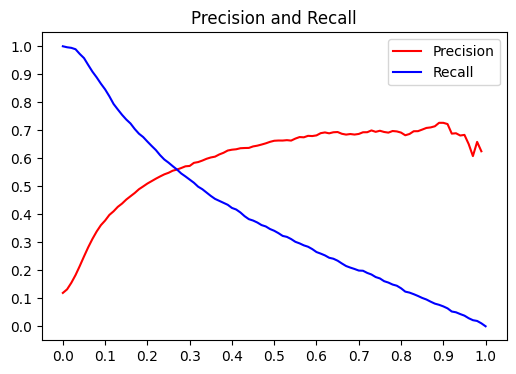

In [60]:
plt.figure(figsize=(6, 4))

plt.plot(df_scores.threshold, df_scores.precision, color='red', label='Precision')
plt.plot(df_scores.threshold, df_scores.recall, color='blue', label='Recall')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.title('Precision and Recall');

In [61]:

df_scores['f1_scores'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)

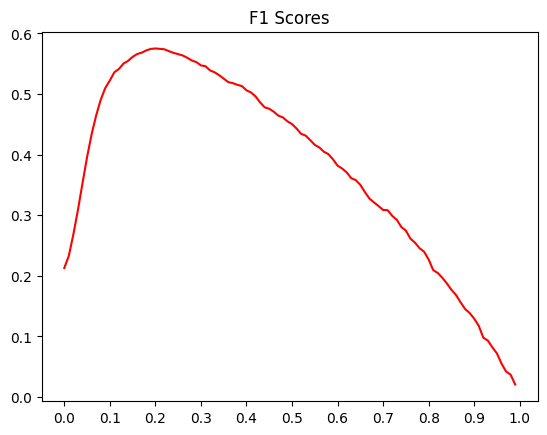

In [63]:
plt.plot(df_scores.threshold, df_scores.f1_scores, color='red')
plt.xticks(np.linspace(0, 1, 11))
plt.title('F1 Scores');

In [77]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [65]:
from sklearn.model_selection import KFold

In [67]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [78]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.y.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

auc = 0.906 ± 0.006


In [79]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]


        y_train = df_train.y.values
        y_val = df_val.y.values


        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)


        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.701 ± 0.009
C=0.001, auc = 0.861 ± 0.007
C=1, auc = 0.906 ± 0.006
